# 5 インスタンスごとの異質性をとらえる〜Individual Conditional Expectation〜

In [1]:
import sys
import warnings
from dataclasses import dataclass
from typing import Any  # 型ヒント用
from __future__ import annotations  # 型ヒント用

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib  # matplotlibの日本語表示対応

# 自作モジュール
sys.path.append("..")
from mli.visualize import get_visualization_setting

np.random.seed(42)
pd.options.display.float_format = "{:.2f}".format
sns.set(**get_visualization_setting())
warnings.simplefilter("ignore")  # warningsを非表示に

In [2]:
from sklearn.model_selection import train_test_split


def generate_simulation_data():
    """シミュレーションデータを生成し、訓練データとテストデータに分割"""
    
    # シミュレーションの設定
    N = 1000
    
    # X0とX1は一様分布から生成
    x0 = np.random.uniform(-1, 1, N)
    x1 = np.random.uniform(-1, 1, N)
    # 二項分布の試行回数を1にすると成功確率0.5のベルヌーイ分布と一致
    x2 = np.random.binomial(1, 0.5, N)
    # ノイズは正規分布からデータを生成
    epsilon = np.random.normal(0, 0.1, N)
    
    # 特徴量をまとめる
    X = np.column_stack((x0, x1, x2))
    
    # 線形和で目的変数を作成
    y = x0 - 5 * x1 + 10 * x1 * x2 + epsilon

    return train_test_split(X, y, test_size=0.2, random_state=42)


# シミュレーションデータを生成
X_train, X_test, y_train, y_test = generate_simulation_data()

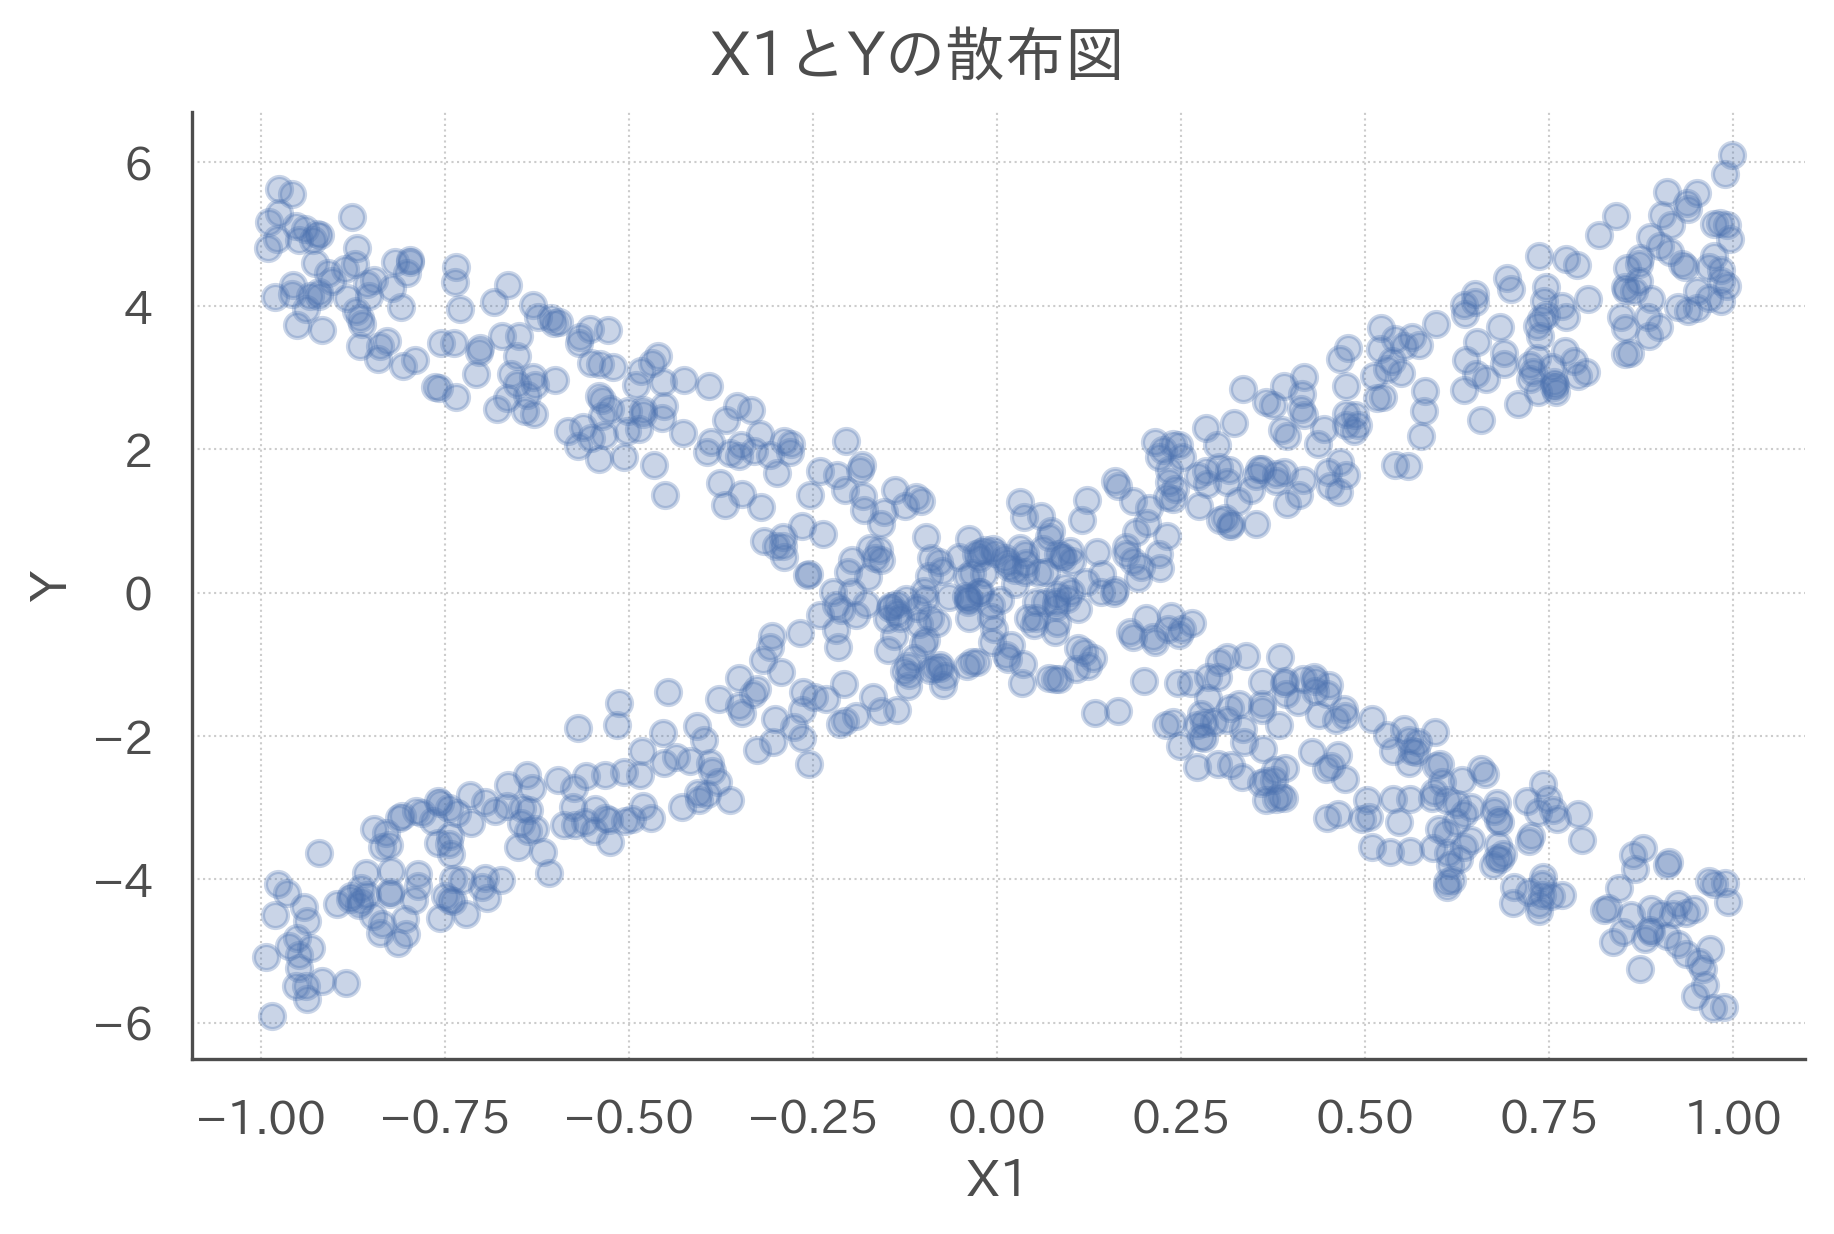

In [3]:
def plot_scatter(x, y, title=None, xlabel=None, ylabel=None):
    """散布図を作成する"""
    fig, ax = plt.subplots()
    ax.scatter(x, y, alpha=0.3)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    fig.suptitle(title)

    fig.show()


# 散布図を可視化
plot_scatter(
    X_train[:, 1], y_train, title="X1とYの散布図", xlabel="X1", ylabel="Y"
)

In [4]:
from sklearn.ensemble import RandomForestRegressor
from mli.metrics import regression_metrics  # 2.3節で作成した自作関数


# Random Forestで予測モデルを構築
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train, y_train)

# 予測精度を確認
regression_metrics(rf, X_test, y_test)

,RMSE,R2
0,0.31,0.99


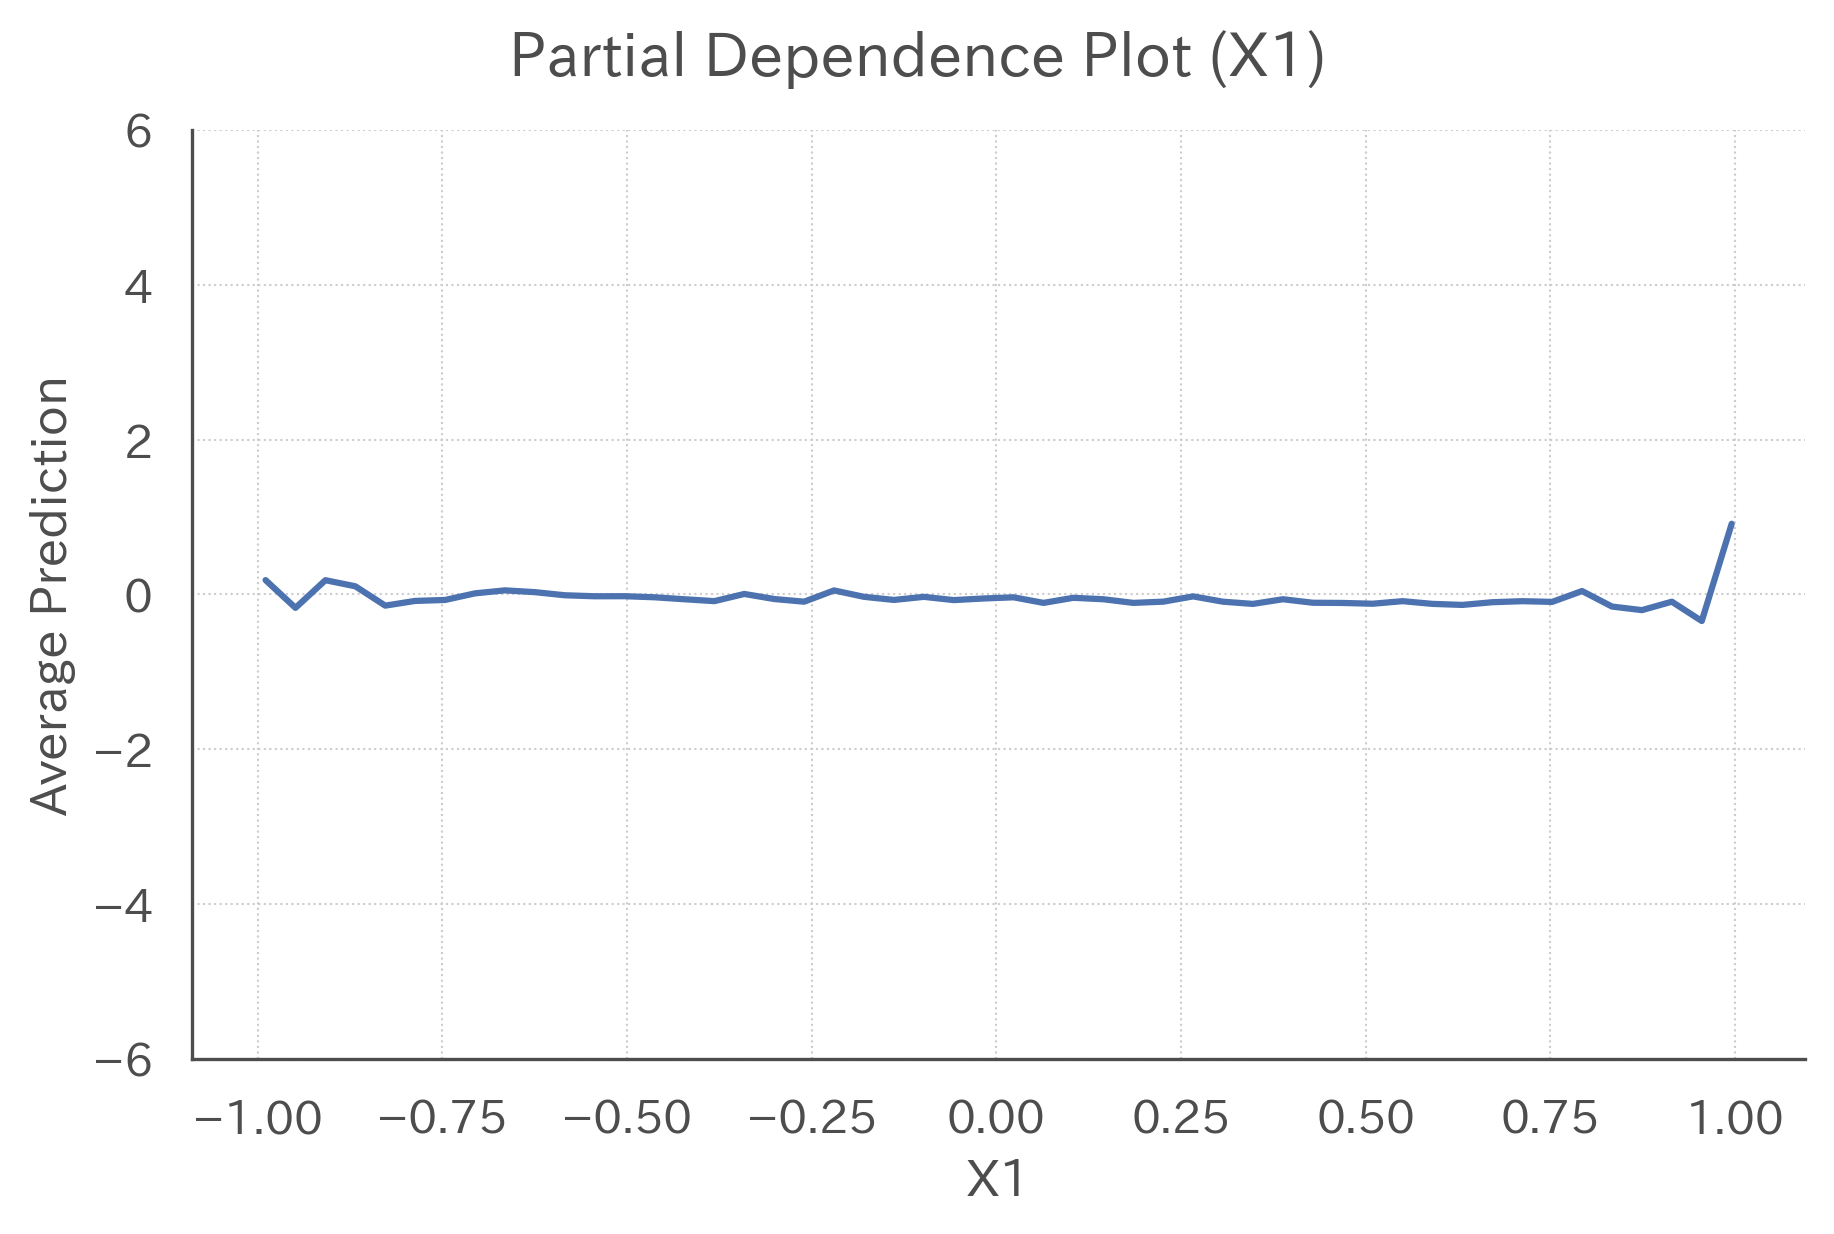

In [5]:
from mli.interpret import PartialDependence  # 4.3節で作成した自作クラス


# X1についてPDを計算し、可視化
pdp = PartialDependence(rf, X_test, ["X0", "X1", "X2"])
pdp.partial_dependence("X1")
pdp.plot(ylim=(-6, 6))

In [6]:
class IndividualConditionalExpectation(PartialDependence):
    """Indivudual Conditional Expectation"""

    def individual_conditional_expectation(
        self, 
        var_name: str, 
        ids_to_compute: list[int], 
        n_grid: int = 50
    ) -> None:
        """ICEを求める

        Args:
            var_name:
                ICEを計算したい変数名
            ids_to_compute:
                ICEを計算したいインスタンスのリスト
            n_grid: 
                グリッドを何分割するか
                細かすぎると値が荒れるが、粗すぎるとうまく関係をとらえられない
                デフォルトは50
        """
        
        # 可視化の際に用いるのでターゲットの変数名を保存
        self.target_var_name = var_name 
        # 変数名に対応するインデックスをもってくる
        var_index = self.var_names.index(var_name)

        # ターゲットの変数を、取りうる値の最大値から最小値まで動かせるようにする
        value_range = np.linspace(
            self.X[:, var_index].min(),
            self.X[:, var_index].max(),
            num=n_grid
        )

        # インスタンスごとのモデルの予測値
        # PDの_counterfactual_prediction()をそのまま使っているので
        # 全データに対して予測してからids_to_computeに絞り込んでいるが
        # 本当は絞り込んでから予測をしたほうが速い
        individual_prediction = np.array([
            self._counterfactual_prediction(var_index, x)[ids_to_compute]
            for x in value_range
        ])

        # ICEをデータフレームとしてまとめる
        self.df_ice = (
            # ICEの値
            pd.DataFrame(data=individual_prediction, columns=ids_to_compute)
            # ICEで用いた特徴量の値。特徴量名を列名としている
            .assign(**{var_name: value_range})
            # 縦持ちに変換して完成
            .melt(id_vars=var_name, var_name="instance", value_name="ice")
        )

        # ICEを計算したインスタンスについての情報も保存しておく
        # 可視化の際に実際の特徴量の値とその予測値をプロットするために用いる
        self.df_instance = (
            # インスタンスの特徴量の値
            pd.DataFrame(
                data=self.X[ids_to_compute],
                columns=self.var_names
            )
            # インスタンスに対する予測値
            .assign(
                instance=ids_to_compute,
                prediction=self.estimator.predict(self.X[ids_to_compute]),
            )
            # 並べ替え
            .loc[:, ["instance", "prediction"] + self.var_names]
        )

    def plot(self, ylim: list[float] | None = None) -> None:
        """ICEを可視化

        Args:
            ylim: Y軸の範囲。特に指定しなければiceの範囲となる。
        """

        fig, ax = plt.subplots()
        # ICEの線
        sns.lineplot(
            self.target_var_name,
            "ice",
            units="instance",
            data=self.df_ice,
            lw=0.8,
            alpha=0.5,
            estimator=None,
            zorder=1,  # zorderを指定することで、線が背面、点が前面にくるようにする
            ax=ax,
        )
        # インスタンスからの実際の予測値を点でプロットしておく
        sns.scatterplot(
            self.target_var_name, 
            "prediction", 
            data=self.df_instance, 
            zorder=2, 
            ax=ax
        )
        ax.set(xlabel=self.target_var_name, ylabel="Prediction", ylim=ylim)
        fig.suptitle(
            f"Individual Conditional Expectation({self.target_var_name})"
        )
        
        fig.show()

In [7]:
# ICEのインスタンスを作成
ice = IndividualConditionalExpectation(rf, X_test, ["X0", "X1", "X2"])

# インスタンス0について、X1のICEを計算
ice.individual_conditional_expectation("X1", [0])

# インスタンス0の特徴量と予測値を出力
ice.df_instance

,instance,prediction,X0,X1,X2
0,0,-3.74,-0.24,0.87,0.00


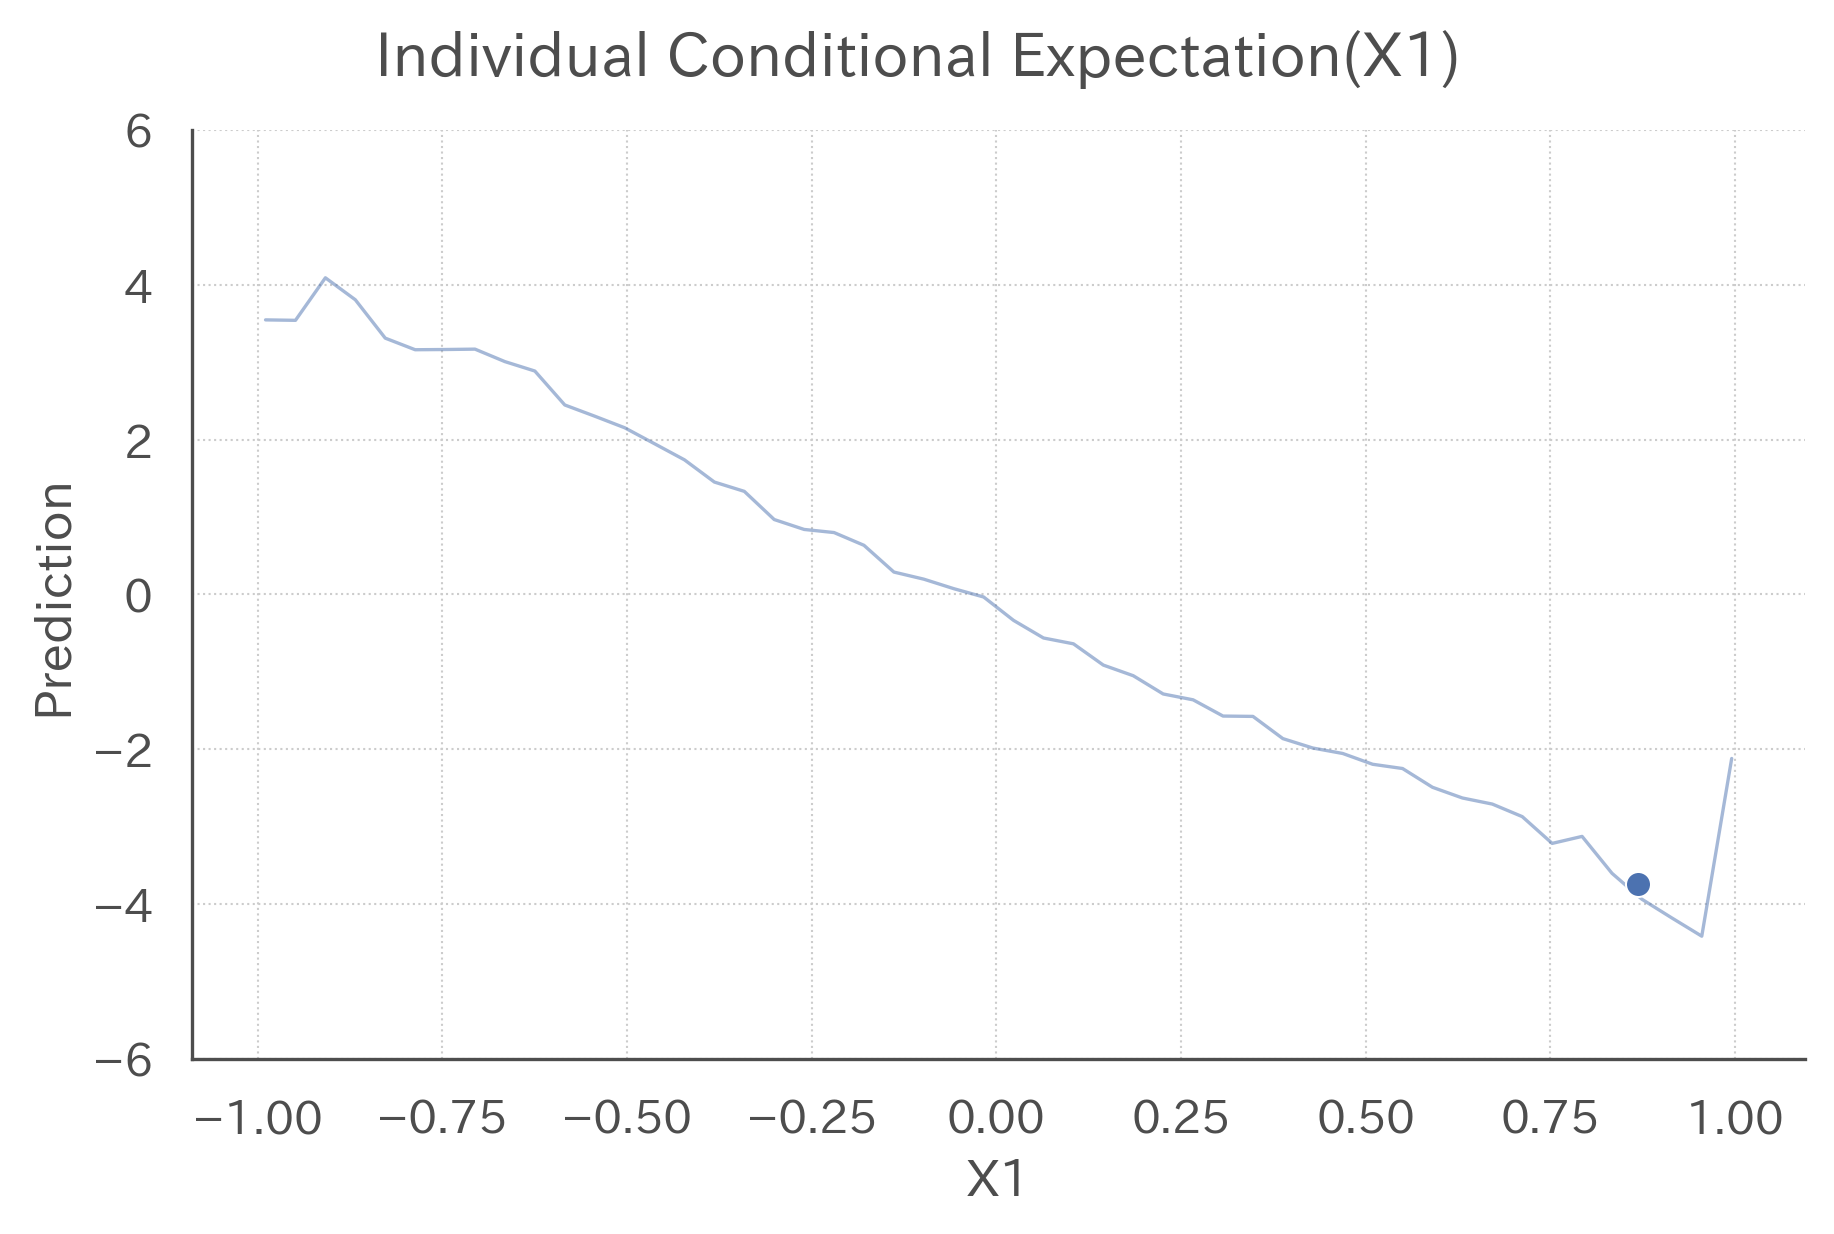

In [8]:
# インスタンス0のICEを可視化
ice.plot(ylim=(-6, 6))

In [9]:
# インスタンス1について、X1のICEを計算
ice.individual_conditional_expectation("X1", [1])

# インスタンス1の特徴量と予測値を出力
ice.df_instance

,instance,prediction,X0,X1,X2
0,1,-2.45,0.63,-0.61,1.00


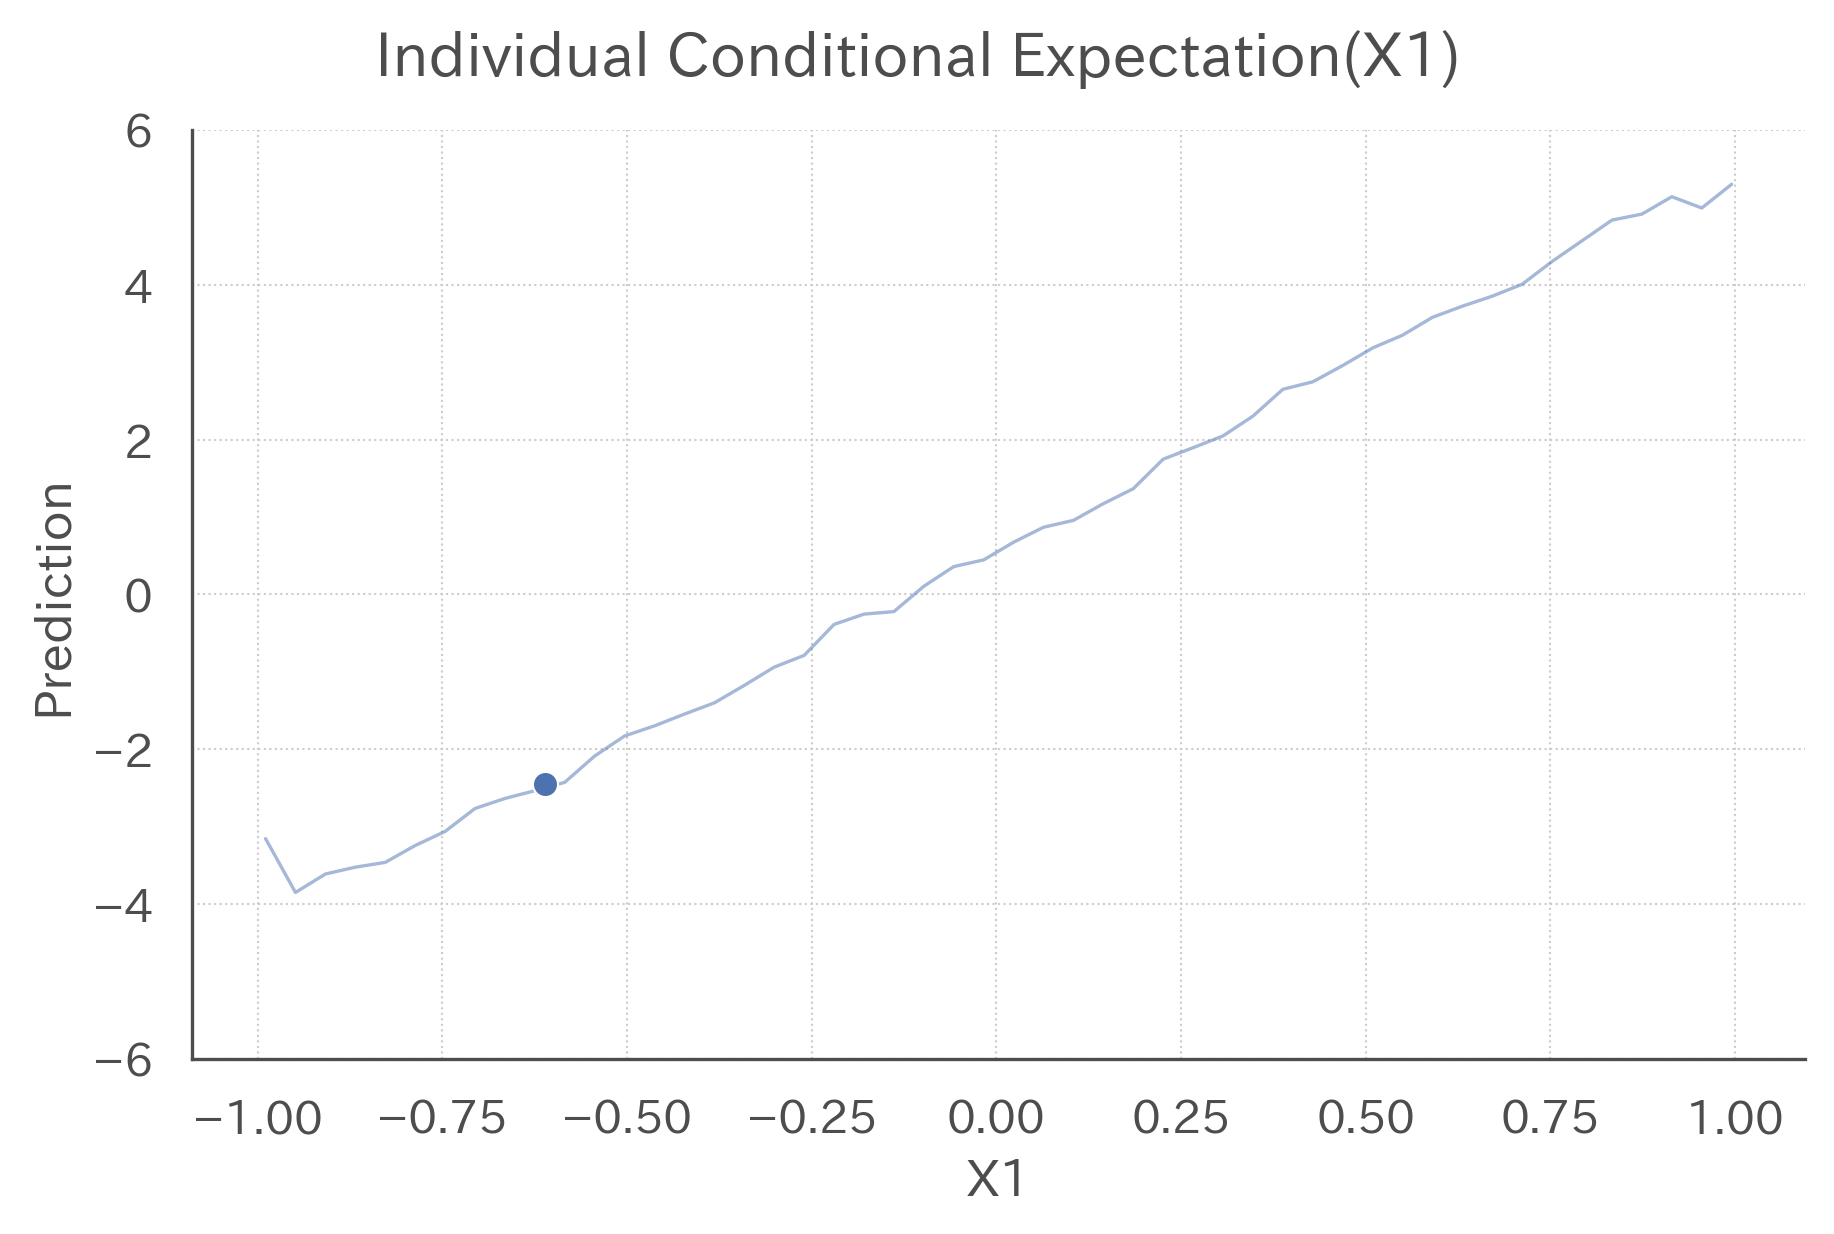

In [10]:
# インスタンス1のICEを可視化
ice.plot(ylim=(-6, 6))

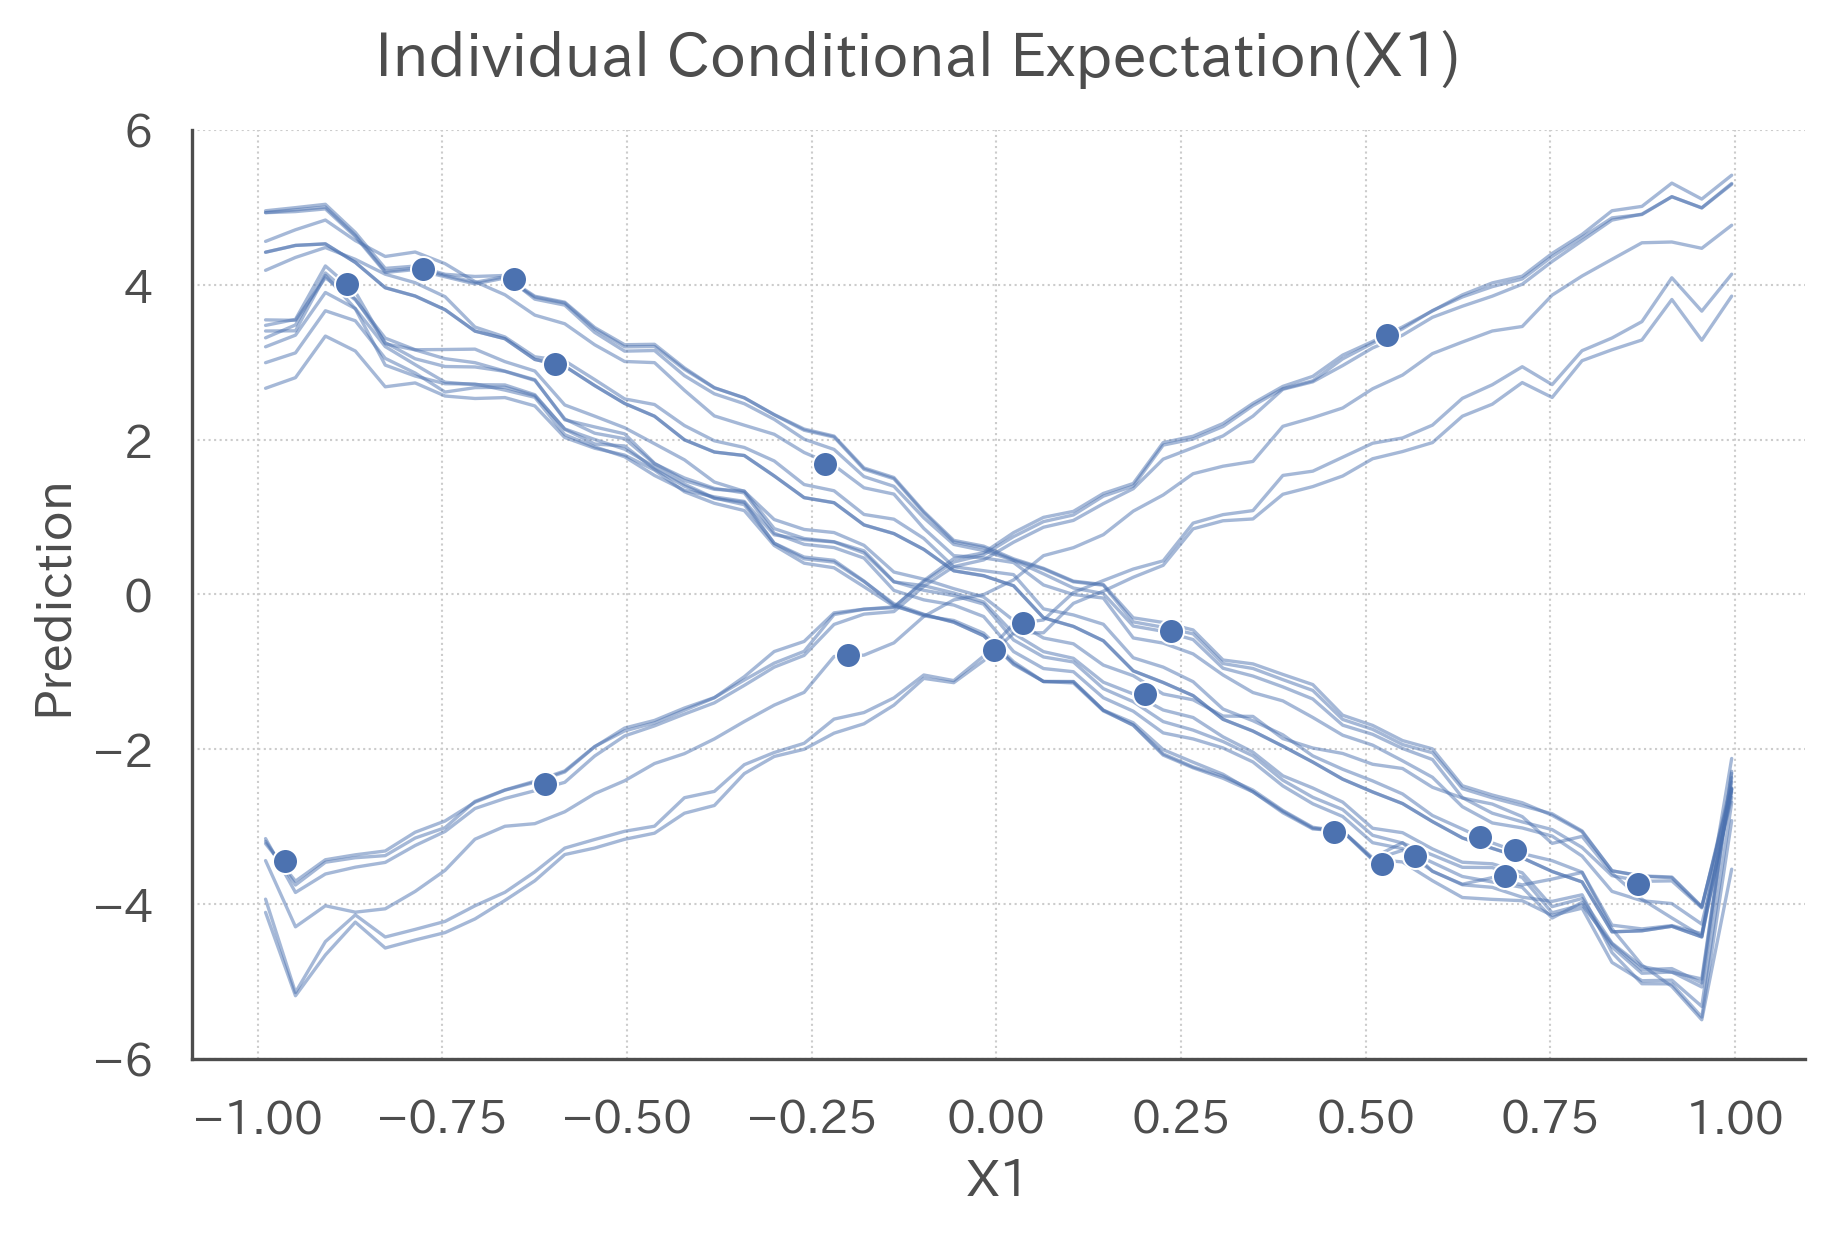

In [11]:
# インスタンス0からインスタンス20までのICEを計算し、可視化
ice.individual_conditional_expectation("X1", range(20))
ice.plot(ylim=(-6, 6))

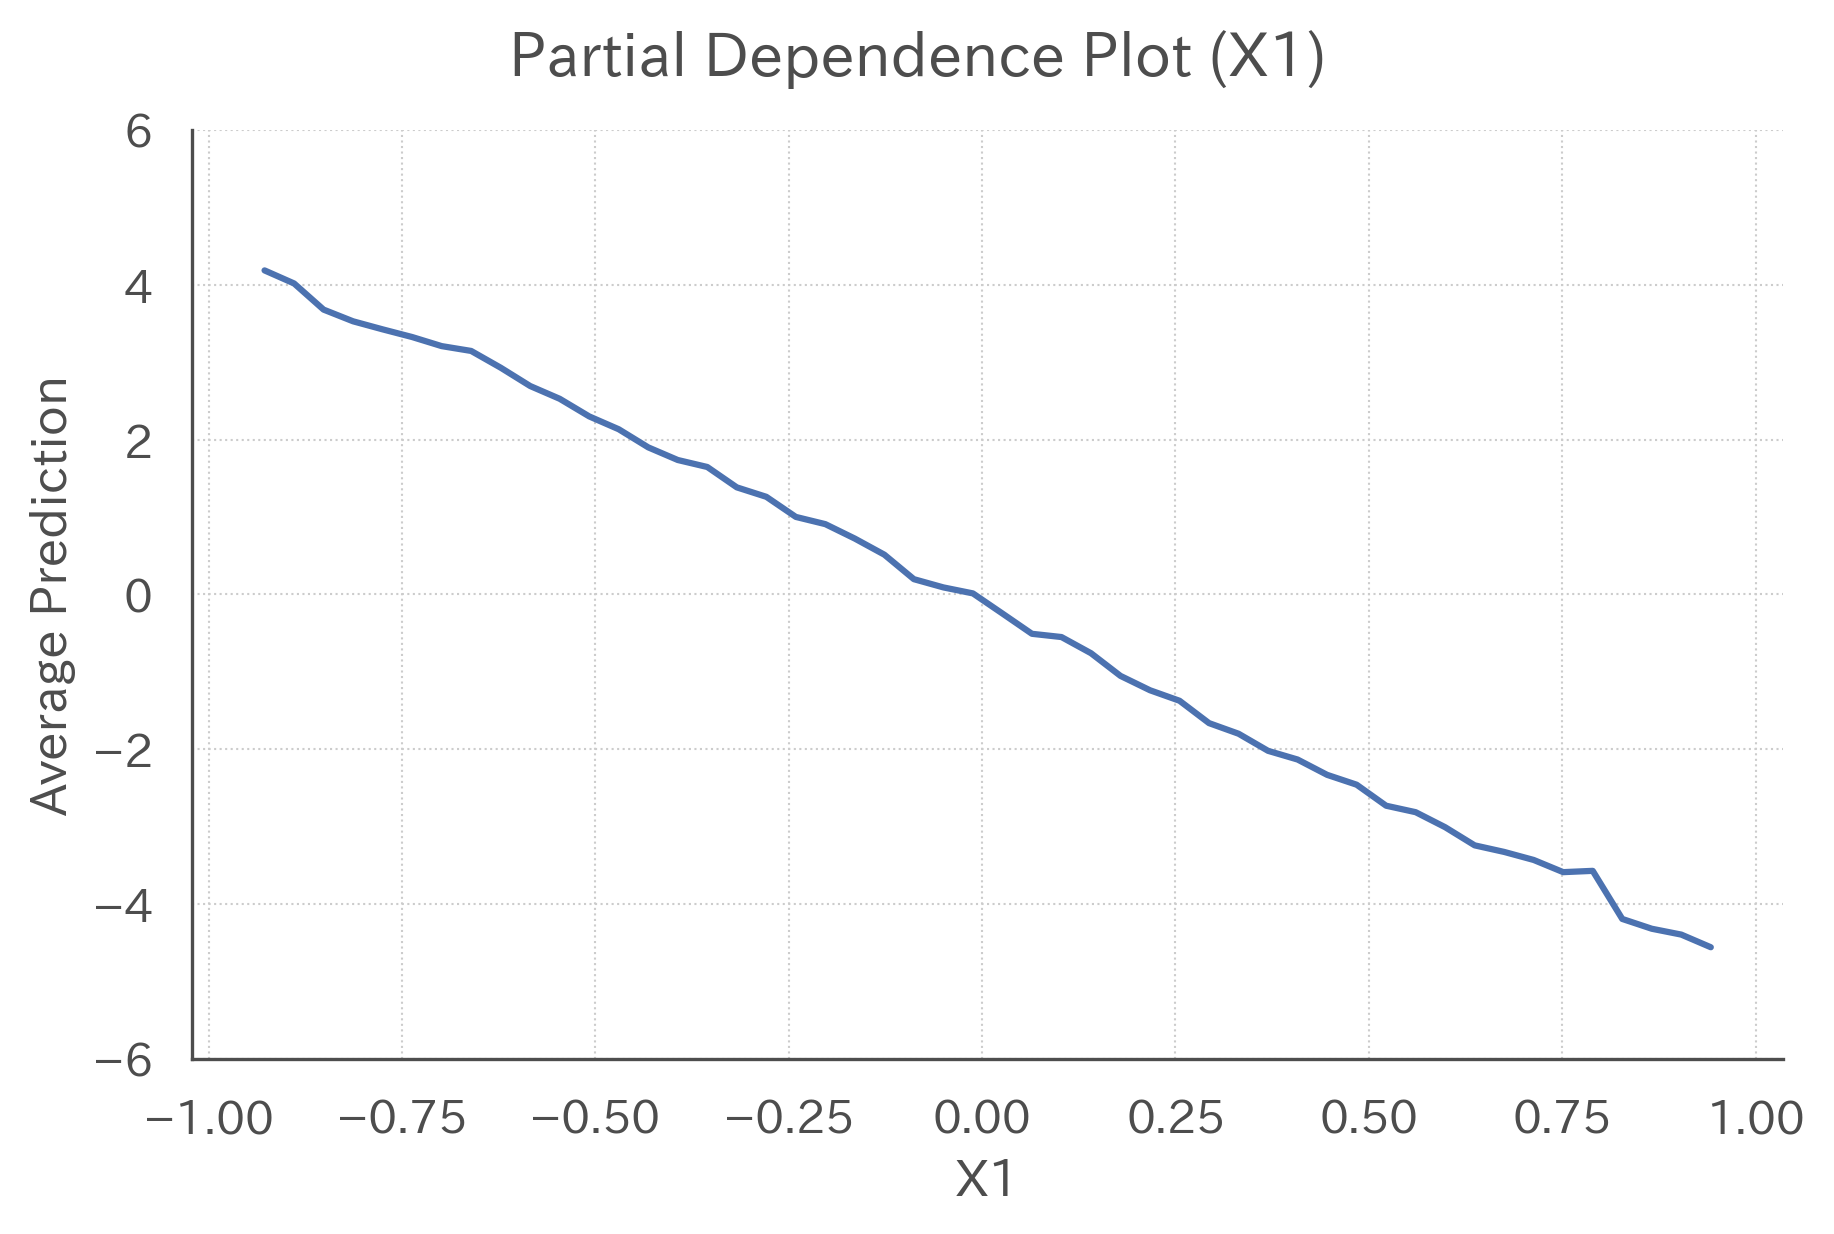

In [12]:
# X2=0のインスタンスに関して、X1のPDを計算
pdp = PartialDependence(rf, X_test[X_test[:, 2] == 0], ["X0", "X1", "X2"])
pdp.partial_dependence("X1")

# PDを可視化
pdp.plot(ylim=(-6, 6))

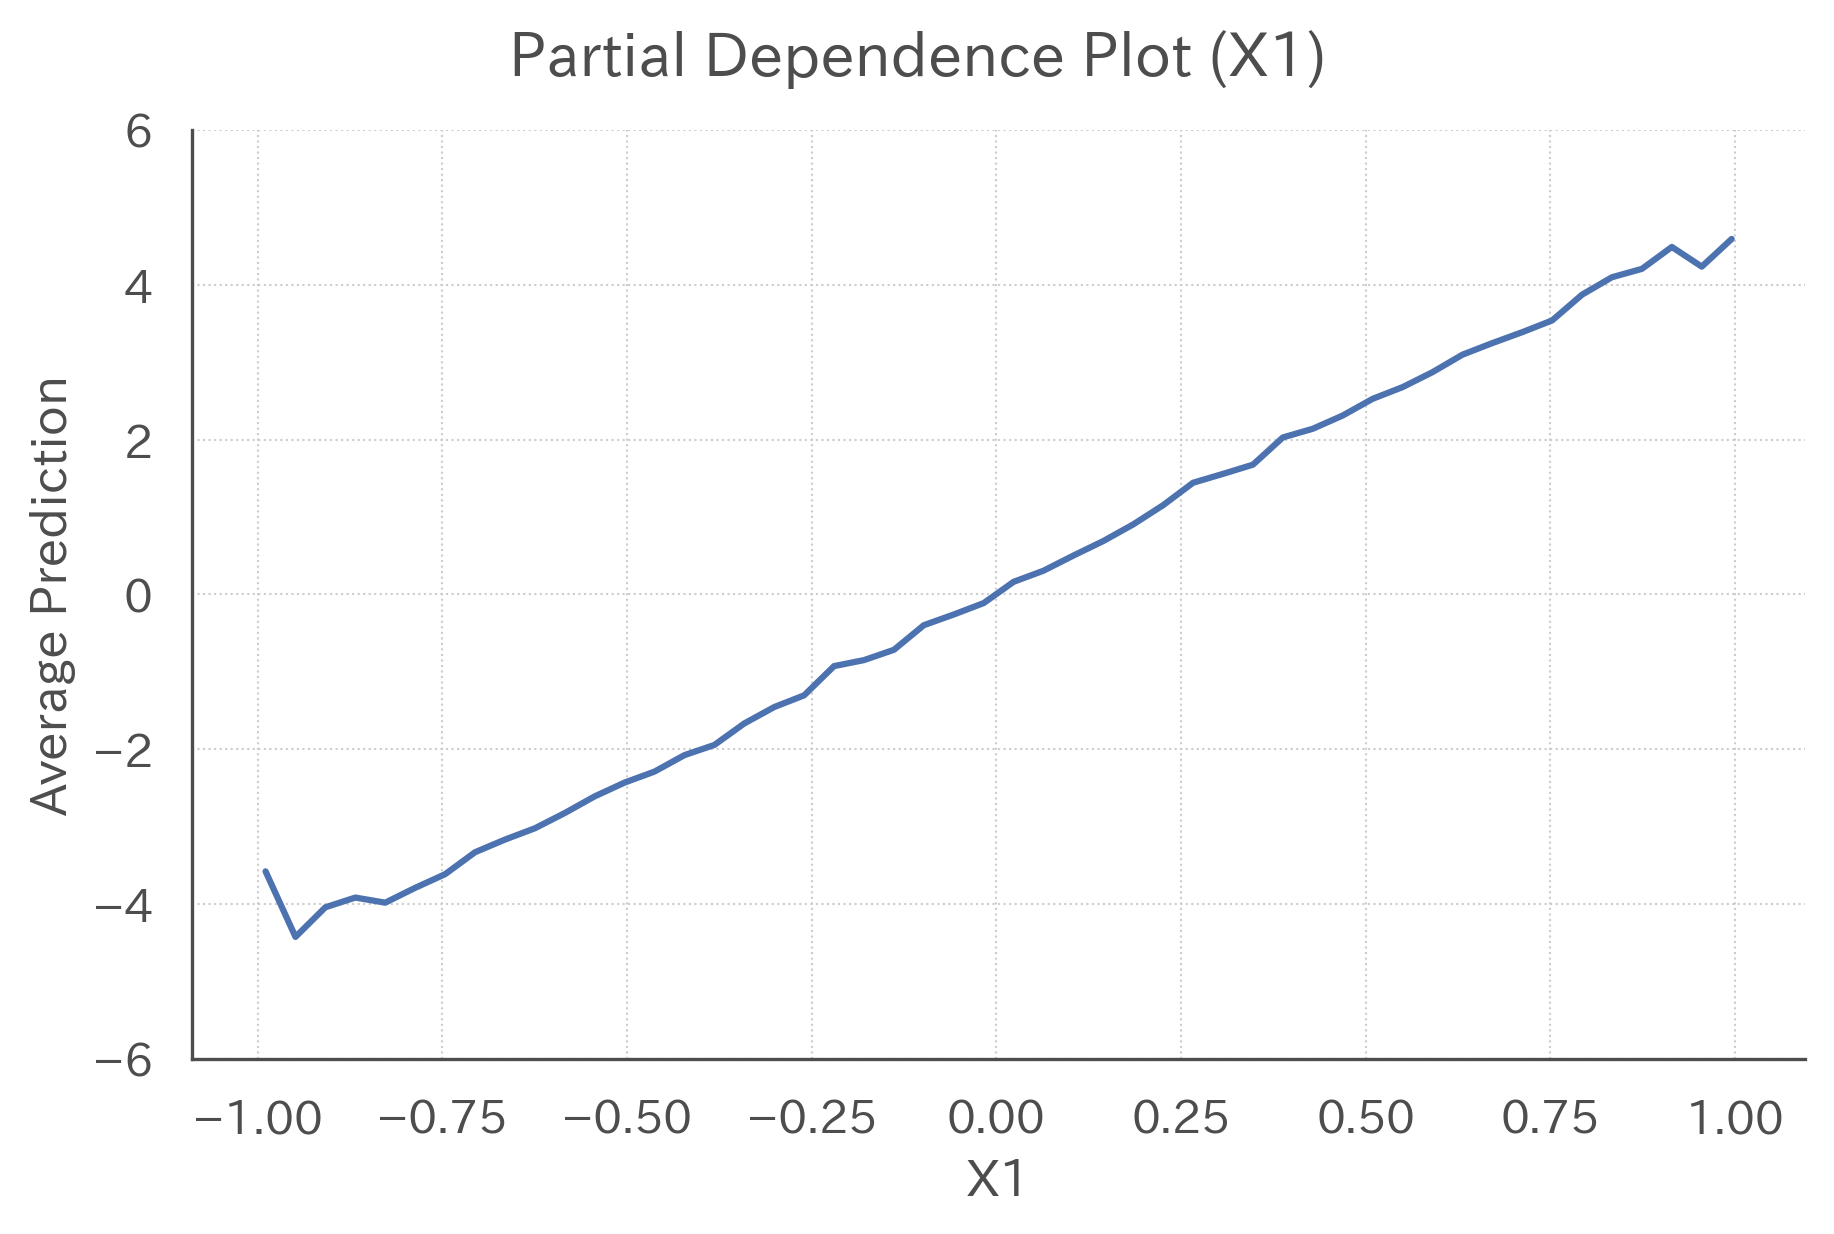

In [13]:
# X2=0のインスタンスに関して、X1のPDを計算
pdp = PartialDependence(rf, X_test[X_test[:, 2] == 1], ["X0", "X1", "X2"])
pdp.partial_dependence("X1")

# PDを可視化
pdp.plot(ylim=(-6, 6))

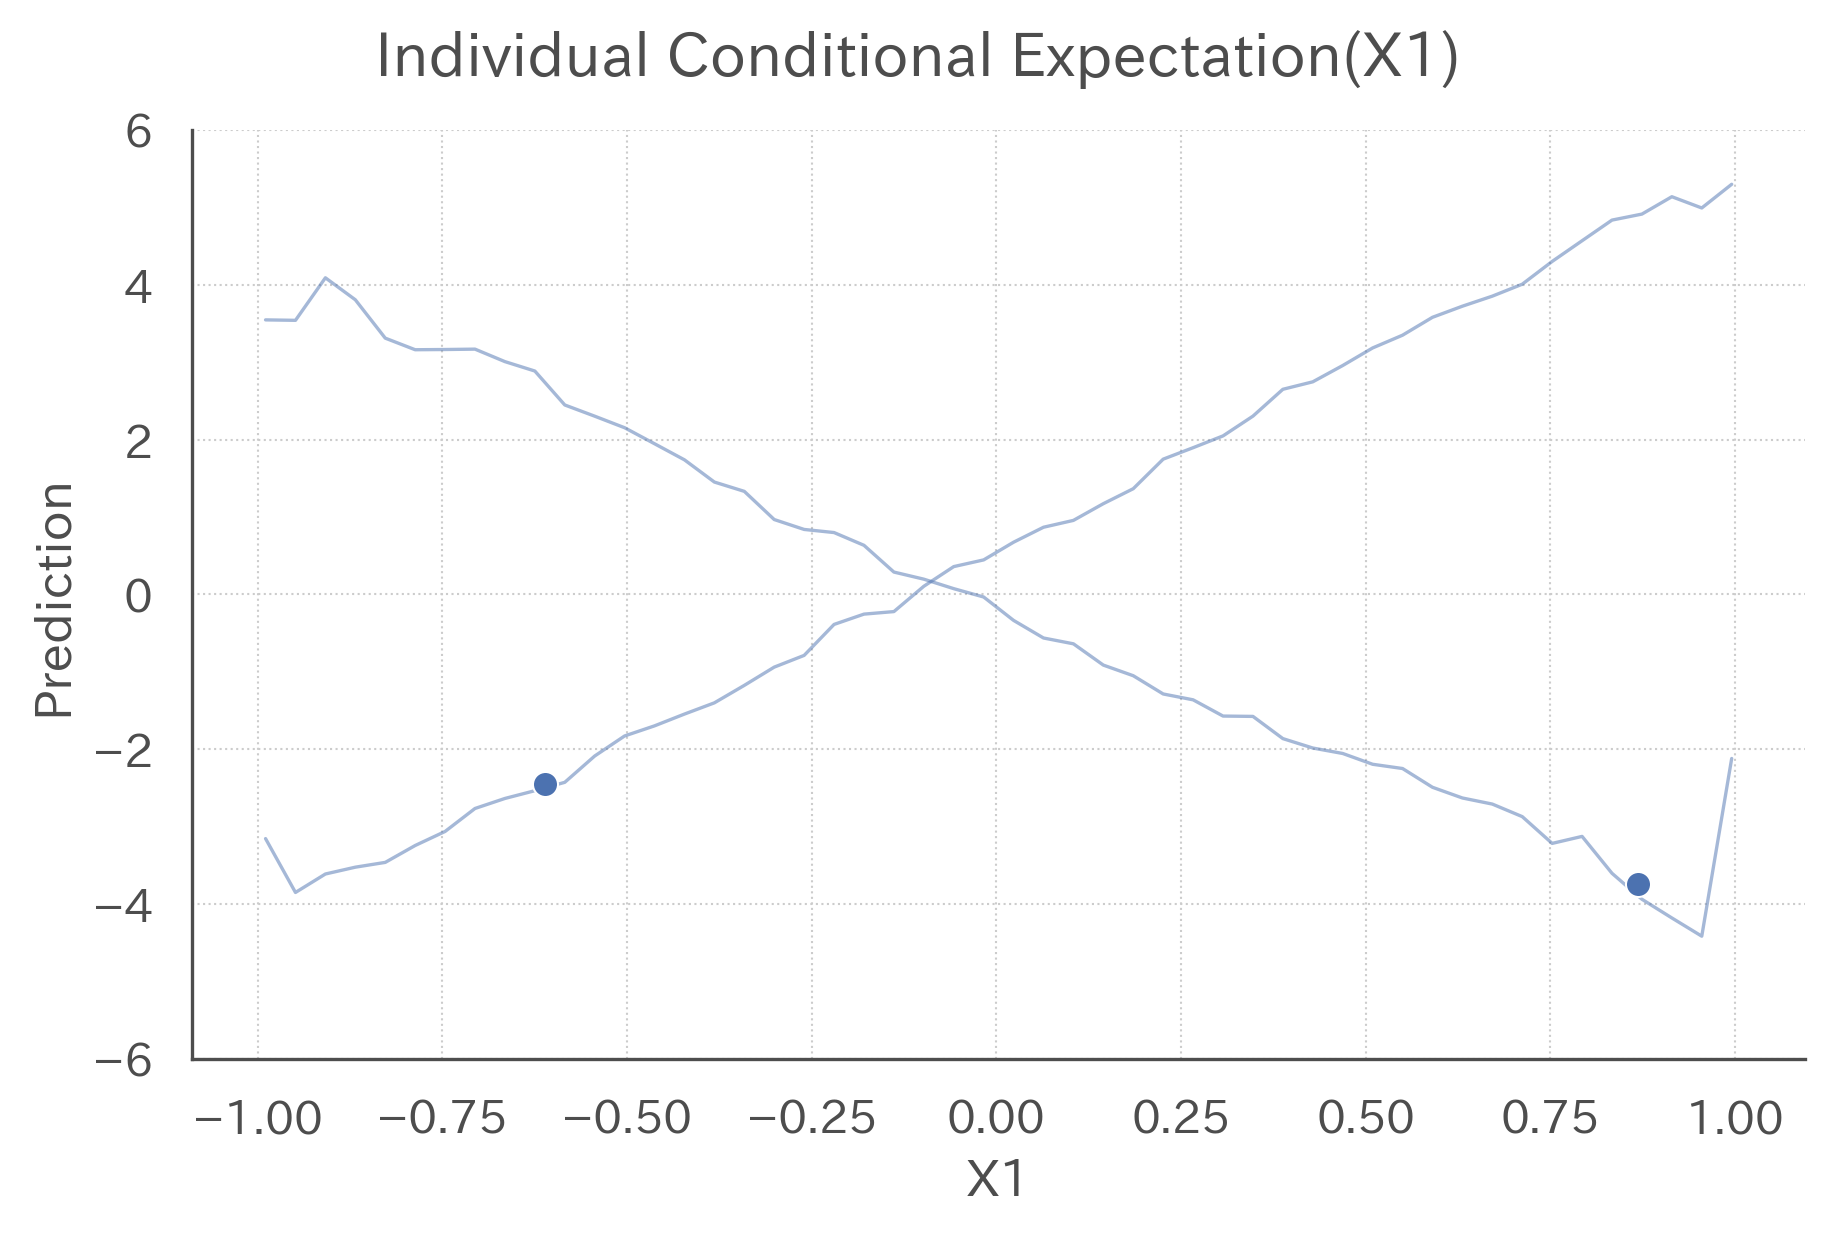

In [14]:
# インスタンス0とインスタンス1に関して、X1のICEを可視化
ice.individual_conditional_expectation("X1", [0, 1])
ice.plot(ylim=(-6, 6))

In [15]:
# インスタンス0とインスタンス1の特徴量の値を確認
ice.df_instance

,instance,prediction,X0,X1,X2
0,0,-3.74,-0.24,0.87,0.00
1,1,-2.45,0.63,-0.61,1.00


In [16]:
def generate_simulation_data():
    """シミュレーションデータを生成し、訓練データとテストデータに分割"""
    
    # シミュレーションの設定
    N=1000
    
    # X0は一様分布から生成
    x0 = np.random.uniform(-1, 1, N)
    # 二項分布の試行回数を1にすると成功確率0.5のベルヌーイ分布と一致
    x2 = np.random.binomial(1, 0.5, N)
    # X1はX2に依存する形にする
    x1 = np.where(
        x2 == 1, 
        np.random.uniform(-0.5, 1, N), 
        np.random.uniform(-1, 0.5, N)
    )
    # ノイズは正規分布からデータを生成
    epsilon = np.random.normal(0, 0.1, N)
    
    # 特徴量をまとめる
    X = np.column_stack((x0, x1, x2))
    
    # 線形和で目的変数を作成
    y = x0 - 5 * x1 + 10 * x1 * x2 + epsilon
    
    return train_test_split(X, y, test_size=0.2, random_state=42)


X_train, X_test, y_train, y_test = generate_simulation_data()

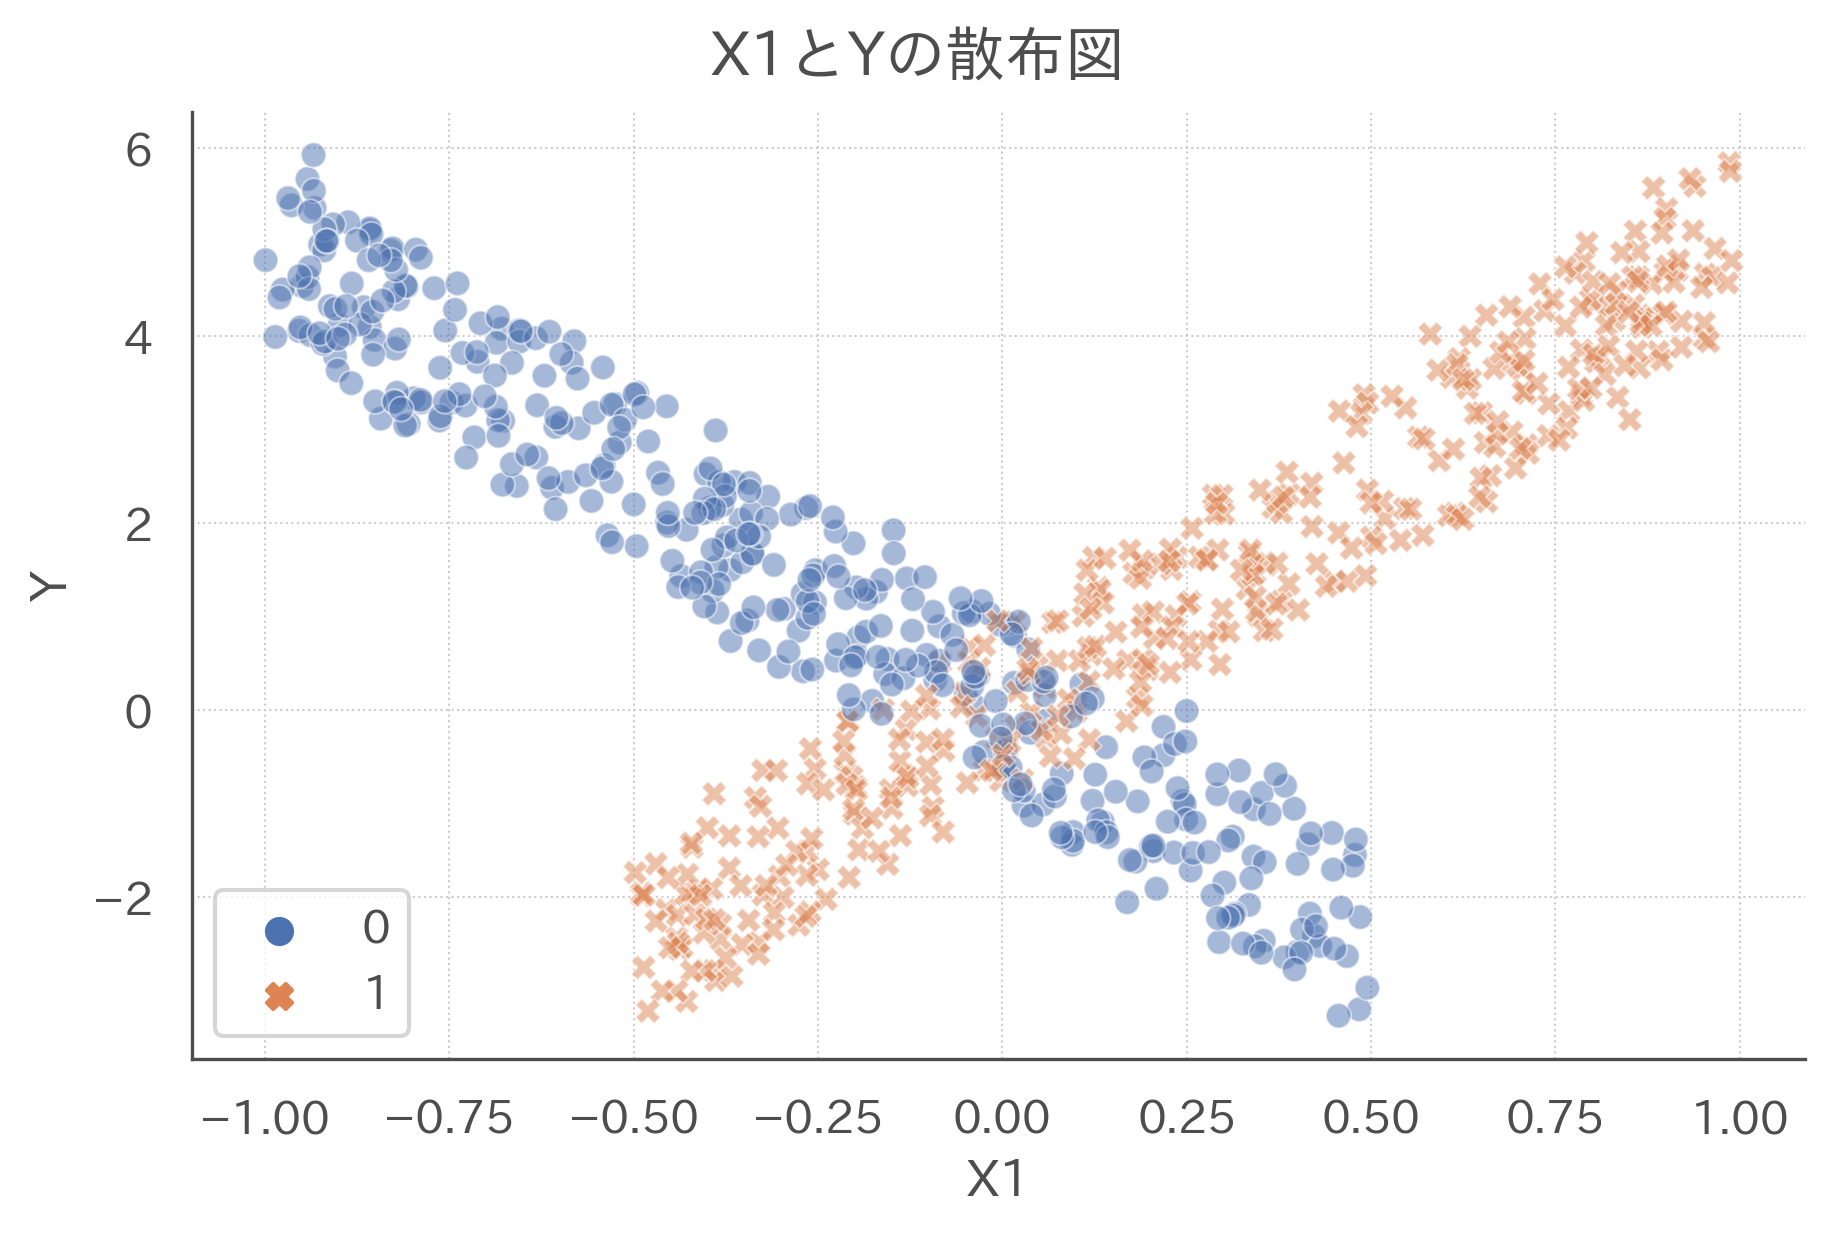

In [17]:
def plot_scatter(x, y, group, title=None, xlabel=None, ylabel=None):
    """散布図を作成する"""
    
    fig, ax = plt.subplots()
    sns.scatterplot(x, y, style=group, hue=group, alpha=0.5, ax=ax)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    fig.suptitle(title)

    fig.show()


# X1とYの散布図を作成
plot_scatter(
    X_train[:, 1],
    y_train,
    X_train[:, 2].astype(int),
    title="X1とYの散布図",
    xlabel="X1",
    ylabel="Y",
)

In [18]:
# Random Forestで予測モデルを構築
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train, y_train)

# 予測精度を確認
regression_metrics(rf, X_test, y_test)

,RMSE,R2
0,0.47,0.96


In [19]:
# インスタンス0に関して、特徴量X1のICEを計算
ice = IndividualConditionalExpectation(rf, X_test, ["X0", "X1", "X2"])
ice.individual_conditional_expectation("X1", [0])

# インスタンスの特徴量を確認
ice.df_instance

,instance,prediction,X0,X1,X2
0,0,1.19,-0.81,-0.43,0.00


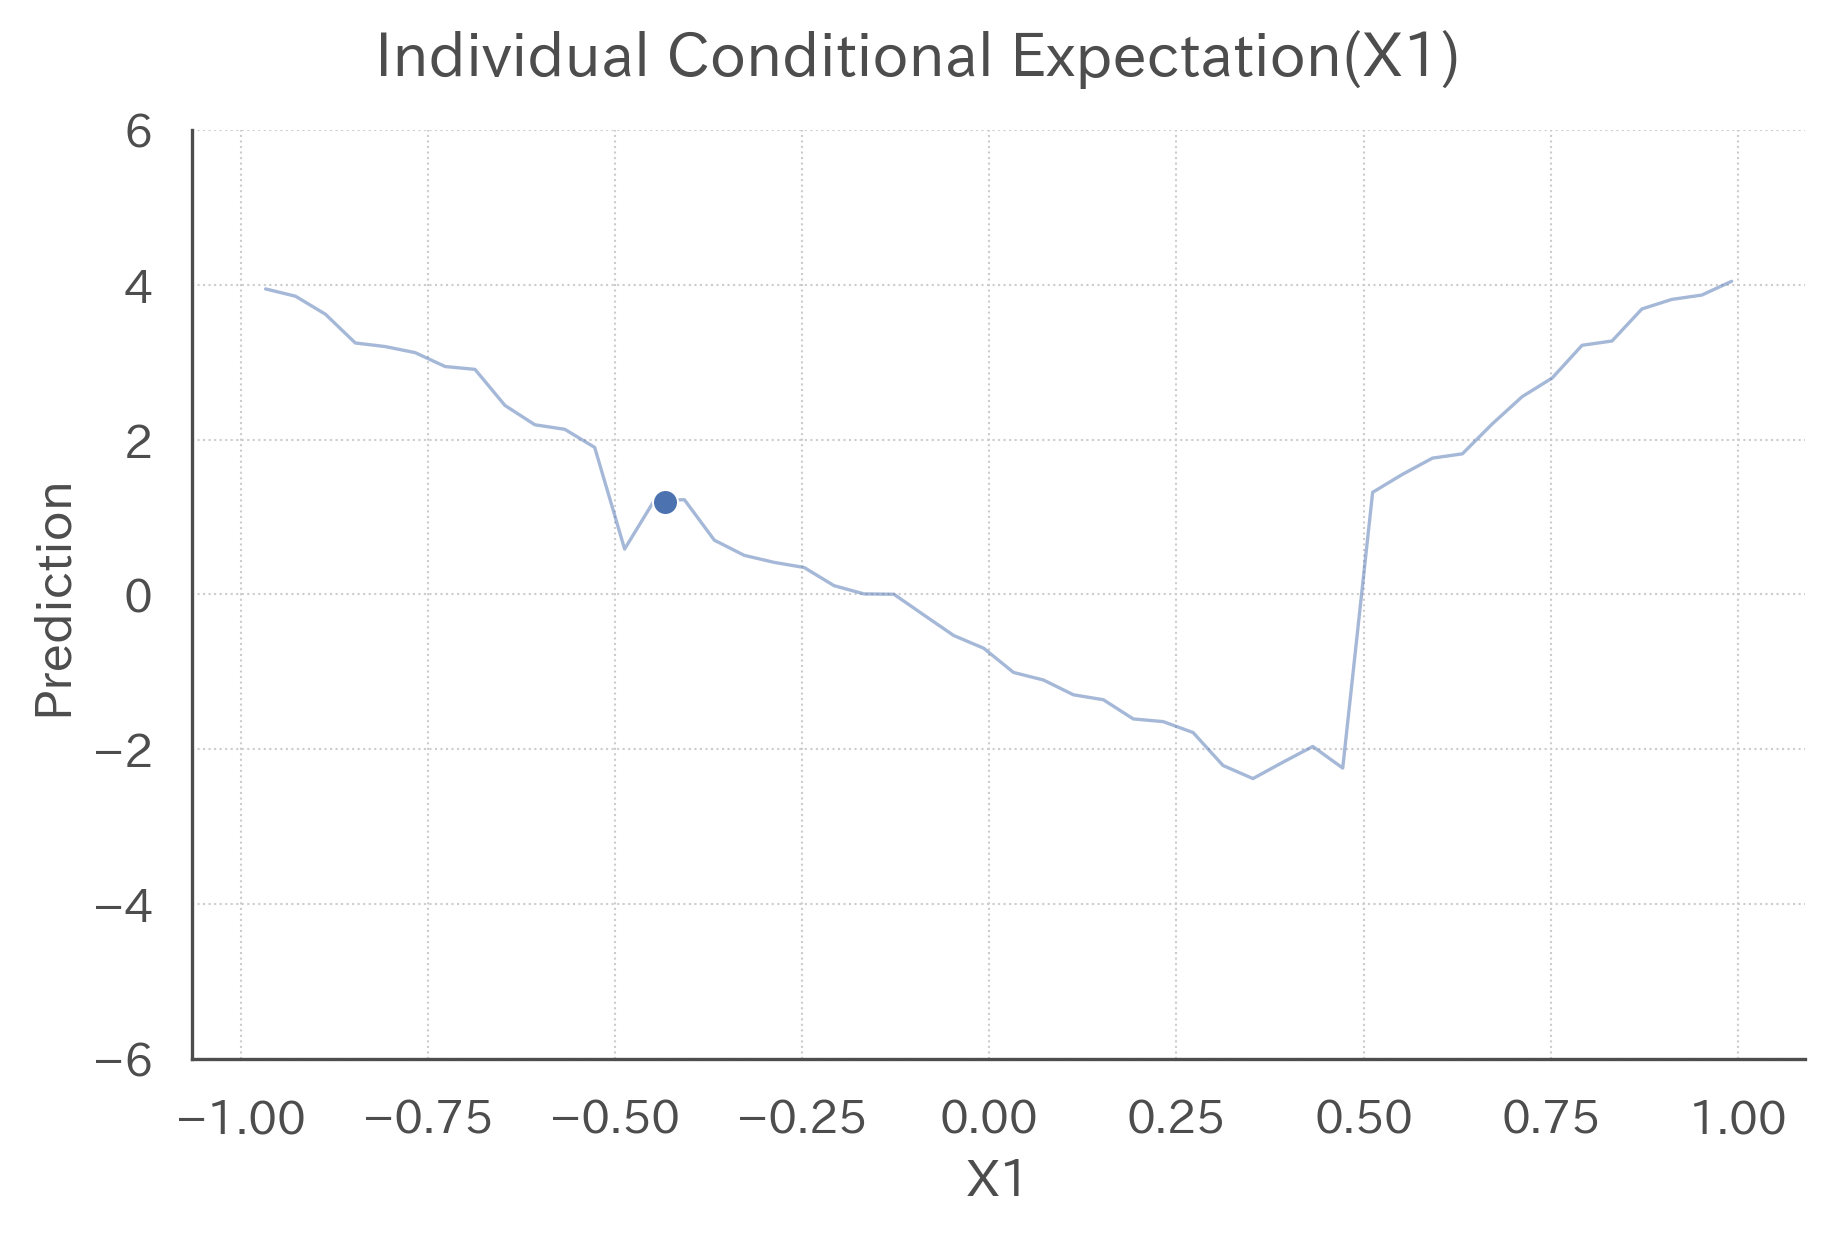

In [20]:
# ICEを可視化
ice.plot(ylim=(-6, 6))

In [21]:
import joblib


# データと学習済みモデルを読み込む
X_train, X_test, y_train, y_test = joblib.load("../data/boston_housing.pkl")
rf = joblib.load("../model/boston_housing_rf.pkl")

In [22]:
from sklearn.inspection import partial_dependence


# PDとICEを計算
ice = partial_dependence(
    estimator=rf,  # 学習済みモデル
    X=X_test,  # ICEを計算したいデータ
    features=["RM"],  # ICEを計算したい特徴量
    kind="both",  # PDとICEの両方を計算
)
ice

{'average': array([[18.85780392, 18.78220588, 18.77509804, 18.74723529, 18.53620588,
         18.68498039, 18.68963725, 18.70292157, 18.70666667, 18.70652941,
         18.7077451 , 18.70991176, 18.7099902 , 18.71266667, 18.69570588,
         18.78512745, 18.78676471, 18.73911765, 18.8157451 , 18.8157451 ,
         18.81963725, 19.13511765, 19.1480098 , 19.29561765, 19.28178431,
         19.29342157, 19.30133333, 19.29657843, 19.29454902, 19.29820588,
         19.305     , 19.31521569, 19.34894118, 19.34862745, 19.35315686,
         19.3725    , 19.3785098 , 19.37987255, 19.37911765, 19.37547059,
         19.35468627, 19.35060784, 19.34788235, 19.33320588, 19.48998039,
         19.49003922, 20.05187255, 20.08277451, 20.16319608, 20.18614706,
         20.1855098 , 20.18246078, 20.18193137, 20.18560784, 20.18733333,
         20.18686275, 20.19282353, 20.18408824, 20.21892157, 20.2259902 ,
         20.27601961, 20.27448039, 20.28603922, 20.32848039, 20.33937255,
         20.35803922, 20.32

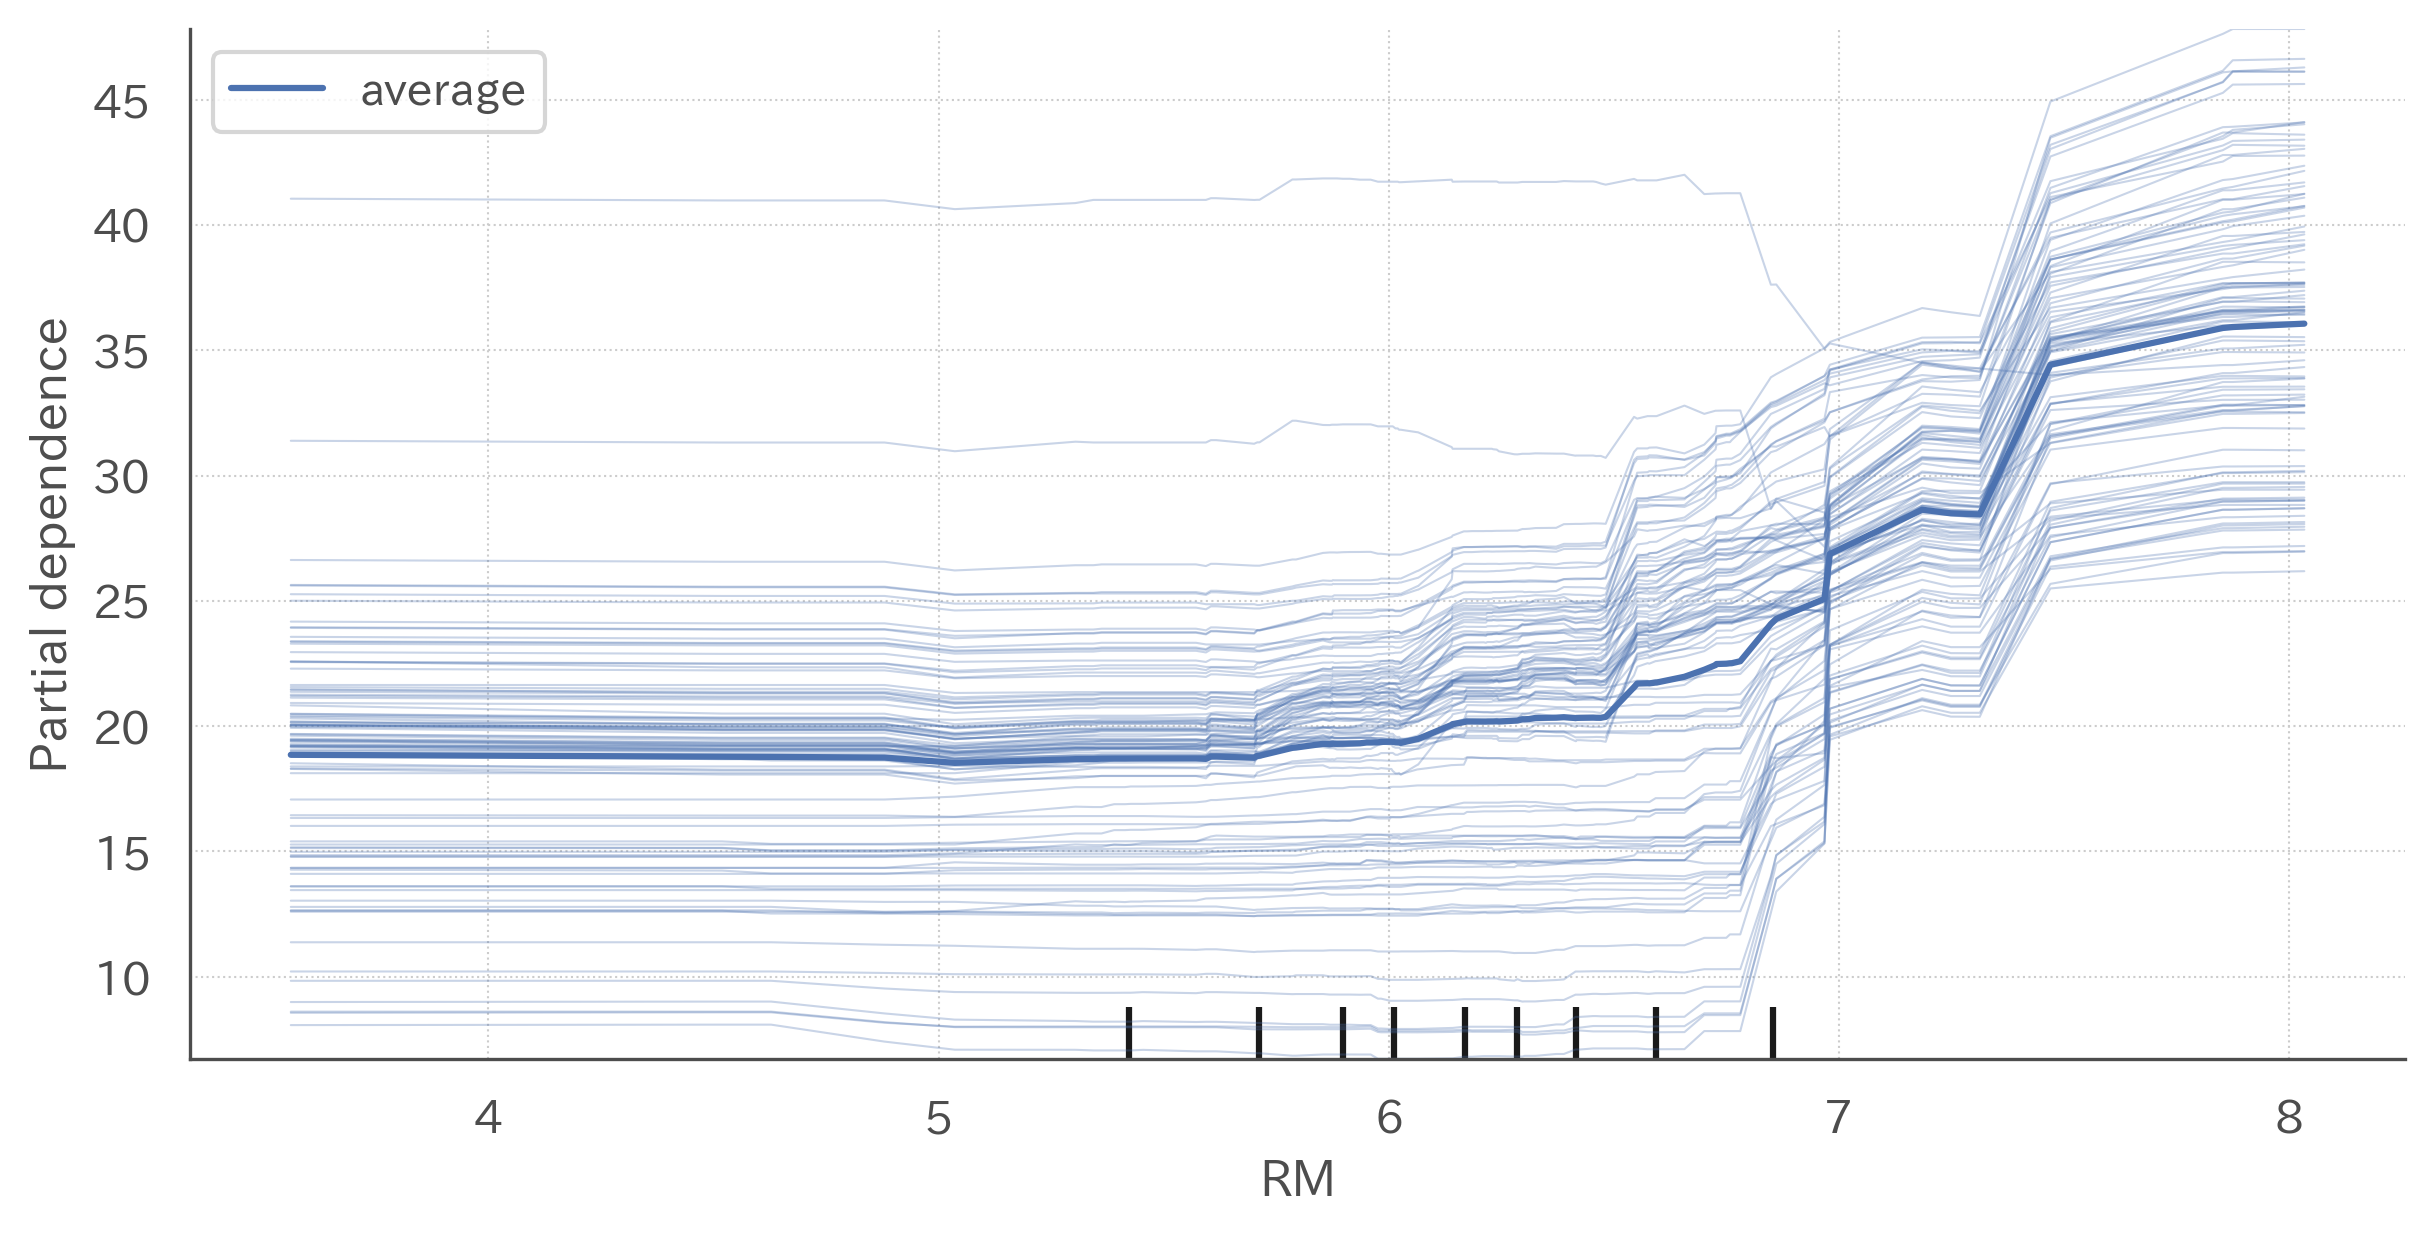

In [23]:
from sklearn.inspection import plot_partial_dependence


def plot_ice():
    """ICEを可視化"""

    fig, ax = plt.subplots(figsize=(8, 4))
    plot_partial_dependence(
        estimator=rf,  # 学習済みモデル
        X=X_test,  # ICEを計算したいデータ
        features=["RM"],  # ICEを計算したい特徴量
        kind="both",  # PDとICEの両方を計算
        ax=ax,
    )

    fig.show()


# ICEを可視化
plot_ice()